___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-3 (RNN)<br><br>Product Amount Forecast by Time<br><h1>

# Dataset Info

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

# Indest Data

In [2]:
df = pd.read_csv('Frozen_Dessert_Production.csv',index_col='DATE', parse_dates = True)

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


# Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [5]:
df.describe()

,IPN31152N
count,573.000
mean,109.896
std,27.951
min,58.660
25%,88.936
50%,107.643
75%,128.278
max,196.174


In [6]:
df.columns = ['Production']

<AxesSubplot:xlabel='DATE'>

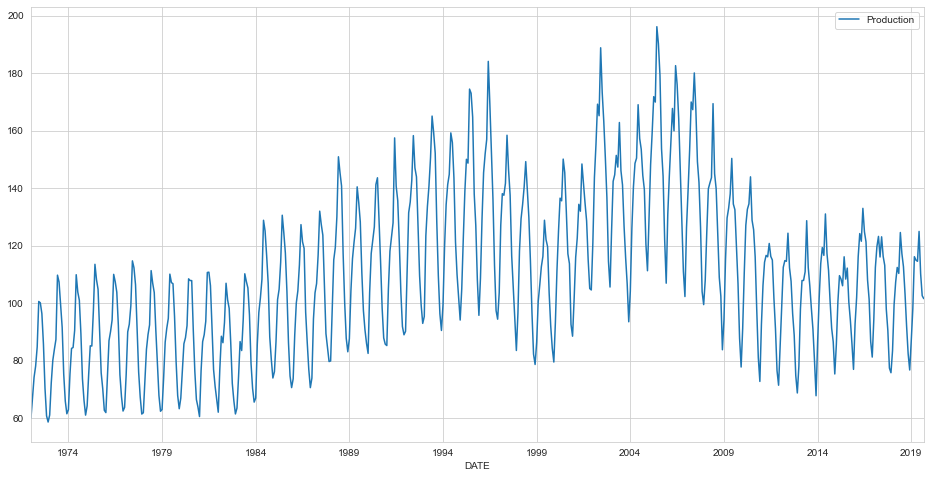

In [7]:
df.plot(figsize=(16,8))

# Preprocessing of Data

## Train Test Split

In [8]:
len(df)

573

In [9]:
test_size = 72

In [10]:
test_ind = len(df)- test_size
test_ind

501

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
train

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2013-05-01,110.913
2013-06-01,128.691
2013-07-01,112.369


In [13]:
test

,Production
DATE,
2013-10-01,90.998
2013-11-01,80.069
2013-12-01,67.803
2014-01-01,86.397
2014-02-01,101.731
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


## Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [19]:
len(generator)

489

In [20]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [21]:
X, y = generator[0]

In [22]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


# Modelling & Model Performance

## with "tanh" activation function

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [24]:
train_scaled.shape

(501, 1)

In [25]:
n_features = 1

In [26]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping and Validation Generator

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [29]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [30]:
model.fit(x = generator,
          epochs = 120,
          validation_data = validation_generator,
          callbacks = [early_stop])

Epoch 1/120
489/489 [==============================] - 7s 8ms/step - loss: 0.0221 - val_loss: 0.0036
Epoch 2/120
489/489 [==============================] - 3s 6ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 3/120
489/489 [==============================] - 3s 6ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 4/120
489/489 [==============================] - 3s 6ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 5/120
489/489 [==============================] - 3s 6ms/step - loss: 0.0049 - val_loss: 0.0063
Epoch 6/120
489/489 [==============================] - 3s 6ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 7/120
489/489 [==============================] - 3s 7ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 8/120
489/489 [==============================] - 3s 7ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 9/120
489/489 [==============================] - 3s 7ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 10/120
489/489 [==============================] - 3s 7ms/step - loss: 0.0036 - val_lo

<AxesSubplot:>

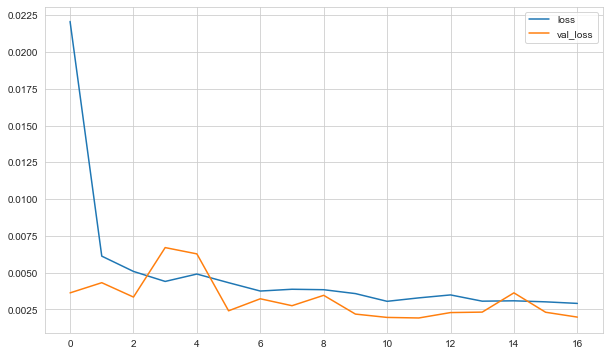

In [31]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluation on Test Data

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [33]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [34]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

1/1 [==============================] - 0s 15ms/step


In [35]:
predictions_scaled

[array([0.17955895], dtype=float32),
 array([0.12056227], dtype=float32),
 array([0.12605143], dtype=float32),
 array([0.18206131], dtype=float32),
 array([0.25180528], dtype=float32),
 array([0.31187338], dtype=float32),
 array([0.35864648], dtype=float32),
 array([0.3929958], dtype=float32),
 array([0.40849957], dtype=float32),
 array([0.3874509], dtype=float32),
 array([0.33605313], dtype=float32),
 array([0.25867197], dtype=float32)]

In [36]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.7654006998722064 
mae: 0.056852791292728376 
mse: 0.003950943407403412 
rmse: 0.06285653034811428


### Inverse Transformation and Comparing

In [37]:
predictions = scaler.inverse_transform(predictions_scaled)

In [38]:
compare = test[:12]

In [39]:
compare['Predictions'] = predictions

<AxesSubplot:xlabel='DATE'>

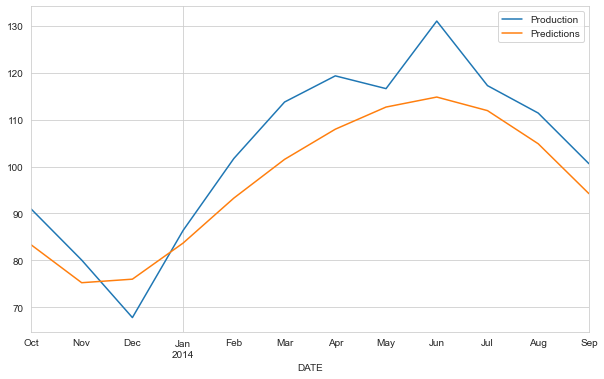

In [40]:
compare.plot()

In [41]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.765400699872206 
mae: 7.818049056549127 
mse: 74.71262704075744 
rmse: 8.643646628637558


## with "relu" activation function

In [42]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [44]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [45]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [46]:
model.fit(x = generator,
          epochs = 120,
          validation_data = validation_generator,
          callbacks = [early_stop])

Epoch 1/120
489/489 [==============================] - 4s 6ms/step - loss: 0.0317 - val_loss: 0.0122
Epoch 2/120
489/489 [==============================] - 3s 5ms/step - loss: 0.0102 - val_loss: 0.0044
Epoch 3/120
489/489 [==============================] - 3s 5ms/step - loss: 0.0079 - val_loss: 0.0039
Epoch 4/120
489/489 [==============================] - 3s 5ms/step - loss: 0.0066 - val_loss: 0.0027
Epoch 5/120
489/489 [==============================] - 3s 5ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 6/120
489/489 [==============================] - 3s 5ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 7/120
489/489 [==============================] - 3s 6ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 8/120
489/489 [==============================] - 3s 6ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 9/120
489/489 [==============================] - 3s 6ms/step - loss: 0.0036 - val_loss: 0.0035


<AxesSubplot:>

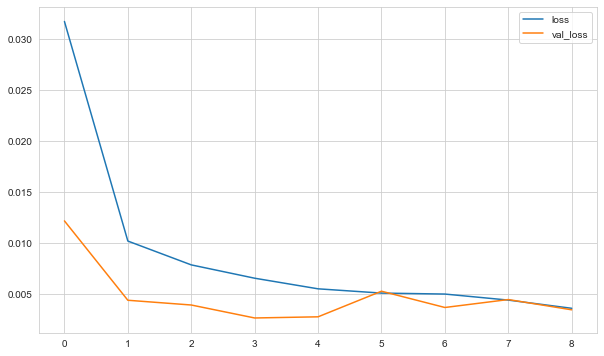

In [47]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluation on Test Data

In [48]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [49]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

1/1 [==============================] - 0s 16ms/step


In [50]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.8532509874404948 
mae: 0.03941219780173042 
mse: 0.002471435521756049 
rmse: 0.04971353459326795


### Inverse Transformation and Comparing

In [51]:
predictions = scaler.inverse_transform(predictions_scaled)

In [52]:
compare = test[:12]
compare['Predictions'] = predictions

<AxesSubplot:xlabel='DATE'>

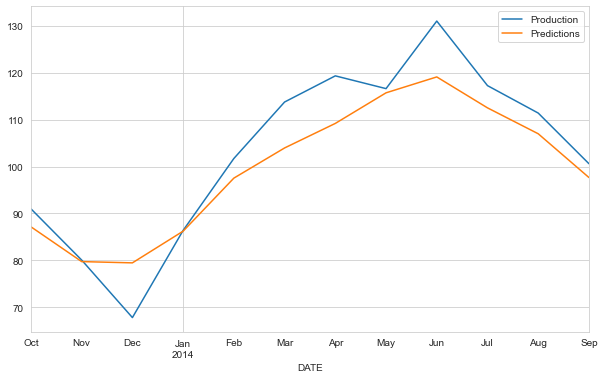

In [53]:
compare.plot()

In [54]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.8532509874404945 
mae: 5.4197250272873845 
mse: 46.735025372988325 
rmse: 6.836302024705193


# Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [55]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [56]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [57]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit(x = generator, epochs=20)

Epoch 1/20
561/561 [==============================] - 4s 5ms/step - loss: 0.0291
Epoch 2/20
561/561 [==============================] - 3s 5ms/step - loss: 0.0117
Epoch 3/20
561/561 [==============================] - 3s 5ms/step - loss: 0.0061
Epoch 4/20
561/561 [==============================] - 3s 6ms/step - loss: 0.0064
Epoch 5/20
561/561 [==============================] - 3s 5ms/step - loss: 0.0062
Epoch 6/20
561/561 [==============================] - 3s 5ms/step - loss: 0.0059
Epoch 7/20
561/561 [==============================] - 3s 5ms/step - loss: 0.0060
Epoch 8/20
561/561 [==============================] - 3s 5ms/step - loss: 0.0056
Epoch 9/20
561/561 [==============================] - 3s 5ms/step - loss: 0.0045
Epoch 10/20
561/561 [==============================] - 3s 5ms/step - loss: 0.0043
Epoch 11/20
561/561 [==============================] - 3s 5ms/step - loss: 0.0037
Epoch 12/20
561/561 [==============================] - 3s 5ms/step - loss: 0.0033
Epoch 13/20
561/561 [====

In [58]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

1/1 [==============================] - 0s 16ms/step


In [59]:
forecast = scaler.inverse_transform(forecast)

In [60]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')

In [61]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

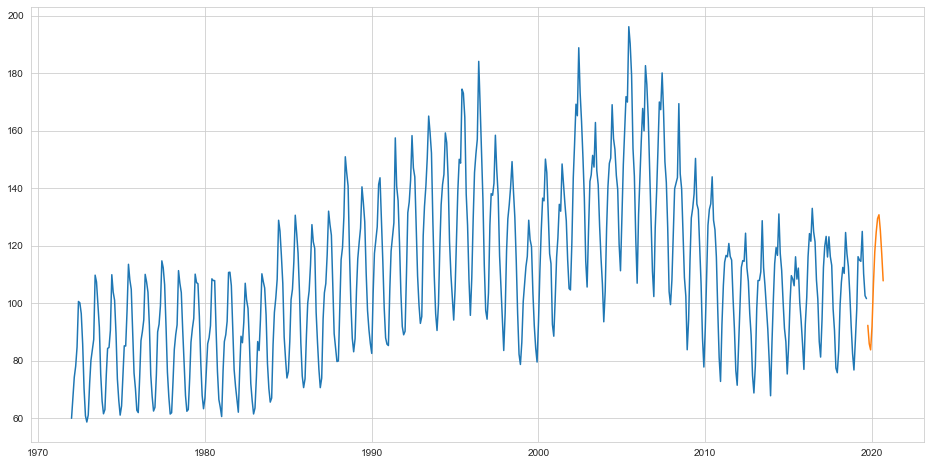

In [62]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Production'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

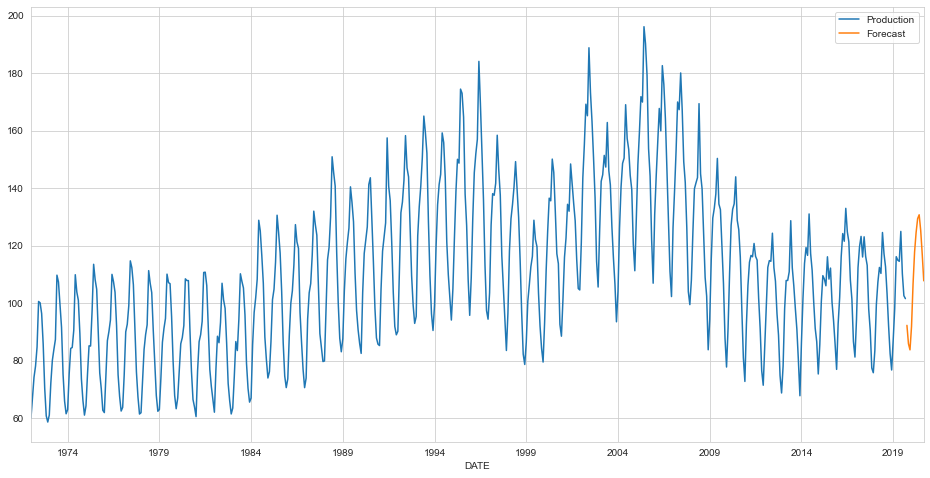

In [63]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___